In [1]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors  
from predicate_construction import construct_predicates 

# Read in GoodReads dataset

In [2]:
DIR = '/scratch/charles/RankPSL/data_construction/goodreads_data_construction'

In [3]:
def load_data(file_name, head = 1000):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the threshold number of lines
            if (head) and (count > head):
                break
    return data

In [4]:
books = load_data(os.path.join(DIR, 'goodreads_books_comics_graphic.json.gz'), head=None)

In [5]:
interactions = load_data(os.path.join(DIR, 'goodreads_interactions_comics_graphic.json.gz'), head=None)

In [6]:
reviews = load_data(os.path.join(DIR, 'goodreads_reviews_comics_graphic.json.gz'), head=None)

In [7]:
# build pandas frame for each dataset
books_df = pd.DataFrame(books)
books_df = books_df.set_index('book_id')
books_df.average_rating = books_df.average_rating.astype(float)

In [8]:
interactions_df = pd.DataFrame(interactions)
interactions_df = interactions_df.set_index(['user_id', 'book_id'])

In [9]:
# development sample from frame
interactions_df = interactions_df.sample(n=5000)

In [10]:
!free

              total        used        free      shared  buff/cache   available
Mem:      132016452    17352320   103427172      683412    11236960   112923872
Swap:       4881404     1161048     3720356


In [11]:
reviews_df = pd.DataFrame(reviews)
reviews_df = reviews_df.set_index(['review_id'])

Apply preprocessing mentioned in paper: 

"We apply the same preprocessing criteria for all five datasets: we
discard users who have never reached the last stage of any behavior
chain and items with fewer than 5 associated interactions in
the system. Statistics and distributions of the above datasets after
preprocessing are included in Table 2. For each dataset, we sample
100,000 interaction chains for validation and another 100,000
for testing. Within each of these two sets, each interaction chain
corresponds to a different user. Data and code are available at
https://github.com/MengtingWan/chainRec."

In [12]:
interactions_df = interactions_df.loc[reviews_df.user_id.unique()]
interactions_df = interactions_df.groupby('book_id').filter(lambda book_frame: book_frame.shape[0] > 5)

In [13]:
interactions_df.index.get_level_values(0).unique().shape

(66,)

In [14]:
# pull out books that are not in interactions dataframe
# is this leaking information since I am filtering the books before train test split?
books_df = books_df[books_df.index.isin(interactions_df.index.unique(level='book_id'))]
books_df.shape

(9, 28)

In [15]:
# pull out reviews by users not in interactions dataframe
# pull out reviews for book not in interactions dataframe
reviews_df = reviews_df.loc[reviews_df.book_id.isin(interactions_df.index.unique(level='book_id'))]
reviews_df = reviews_df.loc[reviews_df.user_id.isin(interactions_df.index.unique(level='user_id'))]
reviews_df.shape

(27, 10)

# Preprocessing

In [16]:
def f_memoize_pandas(s):
    """
    Memoization technique
    """
    dates = {date:pd.to_datetime(date, infer_datetime_format=True, utc=True) for date in s.unique()}
    return s.map(dates)

In [17]:
# interactions
interactions_df.date_added = f_memoize_pandas(interactions_df.date_added)
interactions_df.date_updated = f_memoize_pandas(interactions_df.date_updated)
interactions_df.read_at = f_memoize_pandas(interactions_df.read_at)
interactions_df.started_at = f_memoize_pandas(interactions_df.started_at)

In [18]:
# reviews
reviews_df.date_added = f_memoize_pandas(reviews_df.date_added)
reviews_df.date_updated = f_memoize_pandas(reviews_df.date_updated)
reviews_df.read_at = f_memoize_pandas(reviews_df.read_at)
reviews_df.started_at = f_memoize_pandas(reviews_df.started_at)

In [19]:
# books
books_df.ratings_count = pd.to_numeric(books_df.ratings_count)

# Exploration

In [20]:
display(books_df.shape)
books_df.columns

(9, 28)

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'ratings_count', 'work_id', 'title',
       'title_without_series'],
      dtype='object')

In [21]:
display(interactions_df.shape)
interactions_df.head()

(66, 8)

,,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
user_id,book_id,,,,,,,,
76bbd9959698ffe5085bc9f41acbf519,20898019,d816da9fb7ac426a620b6dee0af5bd29,True,4,,2017-03-09 22:37:50+00:00,2017-03-09 22:38:11+00:00,NaT,NaT
3684b6c9f661e8c89014373a2214ce0c,472331,1832464727b05afeadd80832fdaa56eb,True,5,,2007-10-28 18:50:42+00:00,2009-04-05 19:07:46+00:00,2009-04-05 19:07:46+00:00,NaT
aa32070256100a0b6f5dd447896fc7e9,15196,3ca0a4bb831c84d6b03a01d41a01af91,False,0,,2015-01-06 20:22:49+00:00,2015-01-06 20:22:49+00:00,NaT,NaT
f6deac5c6aa209c6ab22528c1f726d95,25451555,36a5ef33e745d8dd03a219cba86ee27c,False,0,,2015-08-27 03:58:54+00:00,2015-08-27 03:58:55+00:00,NaT,NaT
0524f7c850d174311b8f3561aadeb6e3,156534,1252159161d259a04ab3c18350ac9461,False,0,,2014-11-11 09:22:33+00:00,2014-11-11 09:22:34+00:00,NaT,NaT


In [22]:
display(reviews_df.shape)
reviews_df.columns

(27, 10)

Index(['user_id', 'book_id', 'rating', 'review_text', 'date_added',
       'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments'],
      dtype='object')

Timestamp('2007-10-28 18:50:42+0000', tz='UTC')

Timestamp('2017-09-06 05:57:42+0000', tz='UTC')

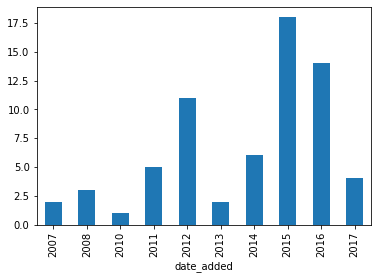

In [23]:
# plot distribution of dates of date_added interactions
display(interactions_df["date_added"].min())
display(interactions_df["date_added"].max())
interactions_df.groupby([interactions_df["date_added"].dt.year])["rating"].count().plot(kind="bar")

Timestamp('2007-12-18 04:51:42+0000', tz='UTC')

Timestamp('2017-09-06 05:57:43+0000', tz='UTC')

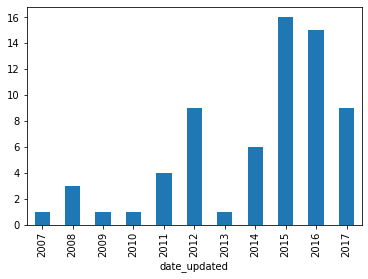

In [24]:
# plot distribution of dates of date_updated interactions
display(interactions_df["date_updated"].min())
display(interactions_df["date_updated"].max())
interactions_df.groupby([interactions_df["date_updated"].dt.year])["rating"].count().plot(kind="bar")

Let every interaction with a book **starting** after 2017 be the test set.

There looks like there is enough interactions to suffice for a test set.  

# Partition train and test interaction data by 2017

In [25]:
# Partition train and test data by 2017
test_interactions_df = interactions_df[interactions_df.date_added.dt.year >= 2017]
test_reviews_df = reviews_df[reviews_df.date_added.dt.year >= 2017]

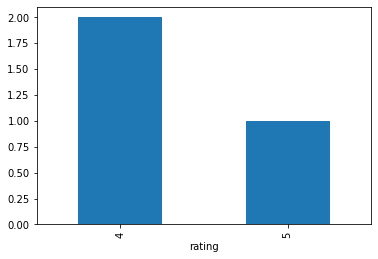

In [26]:
test_interactions_df[test_interactions_df.rating != 0].groupby("rating").rating.count().plot(kind="bar")

In [27]:
# Filter out the 0 ratings, those represent that the user has not yet provided their rating 
test_interactions_df = test_interactions_df[test_interactions_df.rating != 0]

In [28]:
# Create train set
train_interactions_df = interactions_df[interactions_df.date_added.dt.year < 2017]
train_reviews_df = reviews_df[reviews_df.date_added.dt.year < 2017]

**Method for running PSL CLI**

In [29]:
def good_reads_psl(books_df, interactions_df, reviews_df, 
                   obs_interactions, obs_reviews,
                   target_interactions, target_reviews,
                   truth_interactions, truth_reviews, 
                   fold, setting):
    """
    Given the provided datasets, run PSL 
    """
    
    #call predicate construction method and provide sampled dataset 
    construct_predicates(books_df, interactions_df, reviews_df,
                         obs_interactions, obs_reviews,
                         target_interactions, target_reviews,
                         truth_interactions, truth_reviews,
                         fold, setting)
    
    # move the data to the cli data dir
    ! rm -r ../../datasets/goodreads/data/goodreads
    ! mv ./goodreads ../../datasets/goodreads/data/goodreads
    
    # perform PSL inference
    !(cd ../../ ; ./run.sh )

# Full dataset predictions

In [34]:
!pwd

/scratch/charles/RankPSL/data_construction/goodreads_data_construction


In [35]:
# set fold and setting
fold = '0'
setting = 'eval'

# run PSL eval
good_reads_psl(books_df, interactions_df, reviews_df, 
               train_interactions_df.index, train_reviews_df.index,
               test_interactions_df.index, test_reviews_df.index,
               test_interactions_df.index, test_reviews_df.index, 
               fold, setting)

Running inference experiments on datasets: [goodreads].

Running goodreads (#0) -- .
Running goodreads (#0) -- .


In [ ]:
books_df.groupby(books_df.language_code)

# Randomly select observed and unobserved interactions

In [ ]:
def random_data_sample(data_frame, n):
    return data_frame.sample(n).index

In [ ]:
def chronological_data_sample(data_frame, n):
    return None

# I would like a principled way to sample this dataset so we can 

1. get a fair estimate of generalization performance
2. perform cross validation
3. perform inferences on many small graphs that are good representatives of larger distribution to learn weights
4. perform inferences on many small graphs that are good representatives of larger distribution to output an ensemble of inference predictions that can be aggregated by a voting procedure
5. Combine a mixture of psl models. Each PSL model defines a distribution. The mixtures could come from a random walk sampling seeded at each of the targets.

**Notes:**
This is difficult, and I am making a lot of assumptions in order to sample from this multilayer network. There is interesting work to be done here but perhaps a more productive first pass is using the entire dataset and then varying what is observed and unobserved for each weight learning inference iteration. Then we can see if weight learning variance is controlled.

The models for predicting latent preferences are influenced by the structure of the graphs induced by the

    - Relations amongst the books
        - Authors relationship
        - Genre relationship
        - Series relationship
        - user feedback patterns
        
    - Similarities amongst the users
        - feedback similarites
            - shelving 
            - read 
            - rating 
            - review 
        
Perhaps we can sample both graphs induced by these relationship by seperately seeding a random walk at the targets and letting the random walk spread until a prespecified graph size is met.

Then we can join these sampled graphs so that only users from the user sample and books from the book graph sample are used.

To ensure information is not leaked across folds, we should note that the user similarities are based on their ratings of the books.

*Note* that structural information is really only available among the books otherwise, the user relationships are latent and can be infered via rating habits.

Perhaps first pass we sample from the book data set then randomly sample from users and filter so only books that were found in graph sampling are used in PSL model.

In [ ]:
# create author to book data frame
author_df = pd.DataFrame(columns=books_df.index)
author_df.index.name = 'author_id'
for book_id, book in books_df.iterrows():
    for author in book.authors:
        author_df.loc[author['author_id'], book.name] = 1

In [ ]:
# from author information create book_book_by_author_adj_matrix
author_df = author_df.fillna(0)
book_author_matrix = author_df.to_numpy().transpose()
np.matmul(book_author_matrix, book_author_matrix.transpose()).shape
book_book_by_author_adj_matrix = pd.DataFrame(np.matmul(book_author_matrix, book_author_matrix.transpose()), 
                                              index=books_df.index, columns=books_df.index)
book_book_by_author_adj_matrix[book_book_by_author_adj_matrix >= 1] = 1

# remove self loops
book_book_by_author_adj_matrix = (book_book_by_author_adj_matrix - np.eye(book_book_by_author_adj_matrix.shape[0]))

In [ ]:
# create genre to book data frame, genre is from shelf names by users
max_genres = 3
genre_df = pd.DataFrame(columns=books_df.index)
genre_df.index.name = 'genre'
for book_id, book in books_df.iterrows():
    n_genres = 0
    for genre in book.popular_shelves:
        if n_genres >= 3:
            break
        else:
            if genre['name'] != 'to-read':
                genre_df.loc[genre['name'], book.name] = 1
                n_genres = n_genres + 1

In [ ]:
# from genre information create book_book_by_genre_adj_matrix
genre_df = genre_df.fillna(0)
book_genre_matrix = genre_df.to_numpy().transpose()
np.matmul(book_genre_matrix, book_genre_matrix.transpose()).shape
book_book_by_genre_adj_matrix = pd.DataFrame(np.matmul(book_genre_matrix, book_genre_matrix.transpose()),
                                             index=books_df.index, columns=books_df.index)
book_book_by_genre_adj_matrix[book_book_by_genre_adj_matrix >= 1] = 1

# remove self loops
book_book_by_genre_adj_matrix = (book_book_by_genre_adj_matrix - np.eye(book_book_by_genre_adj_matrix.shape[0]))


In [ ]:
# create series to book data frame
series_df = pd.DataFrame(columns=books_df.index)
series_df.index.name = 'series'
for book_id, book in books_df.iterrows():
    for series in book.series:
        series_df.loc[series, book.name] = 1

In [ ]:
# from genre information create book_book_by_genre_adj_matrix
series_df = series_df.fillna(0)
book_series_matrix = series_df.to_numpy().transpose()
np.matmul(book_series_matrix, book_series_matrix.transpose()).shape
book_book_by_series_adj_matrix = pd.DataFrame(np.matmul(book_series_matrix, book_series_matrix.transpose()),
                                             index=books_df.index, columns=books_df.index)
book_book_by_series_adj_matrix[book_book_by_series_adj_matrix >= 1] = 1

# remove self loops
book_book_by_series_adj_matrix = (book_book_by_series_adj_matrix - np.eye(book_book_by_series_adj_matrix.shape[0]))


**Define the Graph Transition Matrix**

A first pass approach is by simply overlapping the adjacency matrices, i.e. summing them, and then normalizing each row (or column) so the row values add to 1. We can then interpret these values as transition probabilities to perform a random walk.



In [ ]:
book_graph_transition = (book_book_by_author_adj_matrix + book_book_by_genre_adj_matrix + book_book_by_series_adj_matrix)
book_graph_transition[book_graph_transition < 0] = 0
book_graph_transition = book_graph_transition / book_graph_transition.sum()

In [ ]:
# Drop interactions for which there is no transition probabilities between the books in the test and train set
non_degenerate_books = book_graph_transition[~(book_graph_transition.isna().sum(axis=0) > 0)].index
book_graph_transition = book_graph_transition.loc[non_degenerate_books, non_degenerate_books]
test_interactions_df = test_interactions_df.loc[(slice(None), book_graph_transition.index), :]
test_reviews_df = test_reviews_df[test_reviews_df.book_id.isin(book_graph_transition.index)]

train_interactions_df = train_interactions_df.loc[(slice(None), book_graph_transition.index), :]
train_reviews_df = train_reviews_df[train_reviews_df.book_id.isin(book_graph_transition.index)]

In [ ]:
# Write train, test, and all graph to a csv file to visualize in gephi for debugging purposes
train_books = train_interactions_df.index.get_level_values(level=1)
test_books = train_interactions_df.index.get_level_values(level=1)

train_book_graph = book_graph_transition.loc[train_books, train_books]
test_book_graph = book_graph_transition.loc[test_books, test_books]

train_book_graph.to_csv('./train_book_graph.csv')
test_book_graph.to_csv('./test_book_graph.csv')
book_graph_transition.to_csv('book_graph.csv')

**Method for sampling from dataset**

In [ ]:
def goodreads_train_sample(n, initial_state=None):
    """
    Method for sampling from the goodreads dataset by performing a random walk on the book graph
    starting at the initial state(s) provided
    n: number of steps on the graph for each initial state
    initial_state: array of starting points for random walk on graph
    return: Sampled books_df, interactions_df, and reviews_df 
    """
    # set initial state, if it was not passed, to a single random book
    if initial_state is None:
        initial_state = np.random.choice(books_df.index, 1)
        
    # obtain random walk sample of books
    sampled_books = set(list(initial_state))
    for state_0 in initial_state:
        state = state_0
        for i in range(n):
            transition_dist = book_graph_transition[state]
            state = np.random.choice(book_graph_transition.index, 1, p=transition_dist)[0]
            sampled_books.add(state)
            
    # Write sampled graph to a csv file to visualize in gephi for debugging purposes
    sampled_book_graph = book_graph_transition.loc[sampled_books, sampled_books]
    sampled_book_graph.to_csv('./sampled_book_graph.csv')

    # use books to sample datasets
    sampled_books_df = books_df.loc[sampled_books, :]
    sampled_interactions_df = train_interactions_df.loc[(slice(None), sampled_books), :]
    sampled_reviews_df = train_reviews_df[train_reviews_df.book_id.isin(sampled_books)]

    return sampled_books_df, sampled_interactions_df, sampled_reviews_df

# How does including more relationship information influence inference performance?

Relationship information enters the model through

- Structured input
    - Scale the amount of graph sampling
    - Scale the amount of blocking
- Structured output
    - Scale the amount of blocking

**Sample From Dataset and run PSL in eval**

In [ ]:
# sample from dataset using the books in the test set
test_books = test_interactions_df.index.unique(level='book_id')
sampled_books_df, sampled_interactions_df, sampled_reviews_df = goodreads_train_sample(5, test_books)

# partition by obs_interactions, target_interactions, and, truth_interactions
obs_interactions = sampled_interactions_df.index
truth_interactions = test_interactions_df.index
target_interactions = truth_interactions

# partition by obs_reviews, target_reviews, and, truth_reviews
obs_reviews = sampled_reviews_df.index
truth_reviews = test_reviews_df.index
target_reviews = truth_reviews

# set fold and setting
fold = '0'
setting = 'eval'

# run PSL eval
good_reads_psl(books_df, interactions_df, reviews_df, 
               obs_interactions, obs_reviews,
               target_interactions, target_reviews,
               truth_interactions, truth_reviews, 
               fold, setting)

In [ ]:
observed_interactions_df = interactions_df.loc[obs_interactions, :]
rating_series = observed_interactions_df[observed_interactions_df.rating > 0]['rating']
rating_series = rating_series - rating_series.min()
rating_series = rating_series / rating_series.max()
rating_series

# How variable is weight learning across dataset samples

# How does weight learning's effectiveness change with dataset size?

# How does weight learning with many different data samples effect weight learning result and effectiveness?

# SCRATCH 

In [272]:
obs_interactions = train_interactions_df.index
target_interactions = train_interactions_df.index
truth_interactions = test_interactions_df.index

# observed predicates
interactions_df.head()

,,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
user_id,book_id,,,,,,,,
ad334e724ac43beec8b46ffa49ccc928,6407014,a76a4c4cb9d218bd3ccc49b7219c205f,False,0,,2016-03-27 05:15:19+00:00,2016-03-27 05:15:20+00:00,NaT,NaT
1ec1f3813fe7b2adfb05c5554f914cc6,15195,cc97eb5e1b2a4ac09abcb193de0e6ee2,True,5,Maus is one of those graphic novels that even ...,2017-10-07 06:11:05+00:00,2017-10-16 00:56:36+00:00,2017-10-08 14:41:49+00:00,2017-10-07 06:11:06+00:00
d5d065cf2549fbfce44a5984b97ffe15,31217834,dd4f3b35a761b19e0a647c52178881e3,True,4,"So, I'm the asshole that really enjoyed this a...",2017-01-17 04:58:07+00:00,2017-01-17 05:33:47+00:00,2017-01-16 08:00:00+00:00,2017-01-16 08:00:00+00:00
c79d0fd40f7cb69b8f724d1567e14ba2,8477057,6bf7a288e41e4a8106be1fcb8498611d,False,0,,2012-08-07 15:57:38+00:00,2012-08-07 15:57:38+00:00,NaT,NaT
1e5028f077c905873f90706a600499fc,18339834,c12f2d7a35c9234a106fd20ca1543063,True,4,,2014-12-13 15:07:18+00:00,2014-12-13 15:07:29+00:00,2014-12-13 15:07:29+00:00,2014-12-13 15:07:18+00:00


In [266]:
book_top_k_sim = item_item_sim.apply(pd.Series.nlargest, n=5).stack()

In [267]:
item_item_series = pd.Series(data=1, index=book_top_k_sim.index)

In [268]:
item_item_series

          book_id 
10088114  10088114    1
          5989573     1
          17412749    1
1011359   1011359     1
10138607  10138607    1
                     ..
9876989   13536803    1
          9876989     1
991197    991197      1
9921208   138396      1
          9921208     1
Length: 2415, dtype: int64